# Layer 5 of the microcircuit model

*NEST Tutorial. 2nd HBP School - Future Computing, August 3-9, 2015, Obergurgl, Austria. Johanna Senk - j.senk@fz-juelich.de*

[1] Potjans, T. C., & Diesmann, M. (2014). The cell-type specific cortical microcircuit: relating structure and activity in a full-scale spiking network model. Cerebral Cortex 24(3):785-806

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First, import NEST and all necessary modules for simulation, analysis and plotting.

In [2]:
import nest
import numpy as np
import nest.raster_plot

## Parameters

The following parameters are extracted from [1], Table 5. Only layer 5 with its excitatory and inhibitory population will be simulated here.

**TODO** Fill in the missing parameters.

In [3]:
# simulation parameters
T = 1000.                  # simulation time (ms)
dt = 0.1                   # simulation resolution (ms)

# network parameters
N_L5E = 4850               # number of neurons in L5E
N_L5I = 1065               # number of neurons in L5I
    
Nsyn_L5E_L5E = 2038173     # number of synapses with presynaptic neuron (pre) in L5E and postsynaptic neuron (post) in L5E 
Nsyn_L5E_L5I = 319602      # number of synapses with pre in L5E and post in L5I
Nsyn_L5I_L5I = 430775      # number of synapses with pre in L5I and post in L5I
Nsyn_L5I_L5E = 2411184     # number of synapses with pre in L5I and post in L5E

K_L5E_ext = 2000           # indegree of excitatory neurons to external poisson drive
K_L5I_ext = 1900           # indegree of inhibitory neurons to external poisson drive

# neuron parameters
neuron_params = {
    'C_m'       : 250.,    # membrane capacity (pF)
    'I_e'       : 0.0,     # external input current (pA)
    'tau_m'     : 10.0,    # membrane time constant (ms)
    't_ref'     : 2.0,     # absolute refractory period (ms)
    'tau_syn_ex': 0.5,     # excitatory postsynaptic current time constant (ms)
    'tau_syn_in': 0.5,     # inhibitory postsynaptic current time constant (ms)
    'V_reset'   : -65.0,   # reset potential (mV)
    'E_L'       : -65.0,   # resting potential (mV)
    'V_th'      : -50.0    # spike threshold (mV)
}

# synapse parameters
w = 87.8                   # mean excitatory weight (pA)
sigma_w = 8.8              # standard deviation of excitatory weight (pA)
g = -4.                    # relative inhibitory weight 

de = 1.5                   # mean spike transmission delay for excitatory presynaptic neurons (ms)
sigma_de = 0.75            # standard deviation 
di = 0.8                   # mean spike transmission delay for inhibitory presynaptic neurons (ms)
sigma_di = 0.4             # standard deviation
 
# input parameters
bg_rate = 8.               # external poisson rate (Hz)
perturbation = False


# 1) Create and connect neurons

**TODO** Reset the simulation kernel for avoiding interferences with previous NEST simulations.

In [4]:
nest.ResetKernel()

In [5]:
nest.SetKernelStatus({'resolution': dt})      # set simulation resolution

**TODO** Create the excitatory and inhibitory neuron populations with neurons of type 'iaf_psc_exp', the correct population sizes, and the given neuron parameters.

In [6]:
pop_L5E = nest.Create('iaf_psc_exp', N_L5E)
nest.SetStatus(pop_L5E, params=neuron_params)

pop_L5I = nest.Create('iaf_psc_exp', N_L5I, params=neuron_params)

The excitatory connections (connections from L5E) are established.

**TODO** Specify the connection dictionary 'conn_dict' for connections to L5E and to L5I. Which connection rule must be used (see connection_management.pdf)?

In [7]:
# excitatory connections (connections from L5E)

# specifying the synapse parameters
weight_dict = {
    'distribution': 'normal_clipped',
    'mu': w,
    'sigma': sigma_w,
    'low': 0.0
}
delay_dict = {
    'distribution': 'normal_clipped',
    'mu': de,
    'sigma': sigma_de,
    'low' : 0.1
}
syn_dict = {
    'weight': weight_dict,
    'delay': delay_dict
}

# connections to L5E
# specifying the connection parameters
conn_dict = {'rule': 'fixed_total_number', 'N': Nsyn_L5E_L5E}
nest.Connect(pop_L5E, pop_L5E, conn_dict, syn_dict)

# connections to L5I
conn_dict = {'rule': 'fixed_total_number', 'N': Nsyn_L5E_L5I}
nest.Connect(pop_L5E, pop_L5I, conn_dict, syn_dict)

**TODO** Create the inhibitory connections (connections from L5I) in the same way as the excitatory ones. Pay attention where parameters must be adjusted.

In [8]:
# specifying the synapse parameters

# specifying the synapse parameters
weight_dict = {
    'distribution': 'normal_clipped',
    'mu': w*g,
    'sigma': np.abs(sigma_w*g),
    'high': 0.0
}
delay_dict = {
    'distribution': 'normal_clipped',
    'mu': di,
    'sigma': sigma_di,
    'low' : 0.1
}
syn_dict = {
    'weight': weight_dict,
    'delay': delay_dict
}

# connections to L5E
# specifying the connection parameters
conn_dict = {'rule': 'fixed_total_number', 'N': Nsyn_L5I_L5E}
nest.Connect(pop_L5I, pop_L5E, conn_dict, syn_dict)

# connections to L5I
conn_dict = {'rule': 'fixed_total_number', 'N': Nsyn_L5I_L5I}
nest.Connect(pop_L5I, pop_L5I, conn_dict, syn_dict)


# 2) Create and connect devices

Poisson generators simulate neuron firing with the statistics of Poisson processes. Here, they emulate external excitatory input to the network.

**TODO** Create two poisson generators and connect them to the respective populations.
The given external rate 'bg_rate' corresponds to the rate communicated by one synapse. How must the key 'rate' of the poisson generator's 'params' dictionary be set? The connection rule is 'all_to_all'. For weights and delays, just take the the mean values given for excitatory neurons.

In [9]:
# connections to L5E
poisson_generator_L5E = nest.Create('poisson_generator', params={'rate': bg_rate * K_L5E_ext})
nest.Connect(poisson_generator_L5E, pop_L5E, 'all_to_all', {'weight': w, 'delay': de})

# connections to L5I
poisson_generator_L5I = nest.Create('poisson_generator', params={'rate': bg_rate * K_L5I_ext})
nest.Connect(poisson_generator_L5I, pop_L5I, 'all_to_all', {'weight': w, 'delay': de})

**TODO** Set up and connect two spike detectors, one for each population.

In [10]:
sd_L5E = nest.Create('spike_recorder')
nest.Connect(pop_L5E, sd_L5E, 'all_to_all')

sd_L5I = nest.Create('spike_recorder')
nest.Connect(pop_L5I, sd_L5I, 'all_to_all')

# 4*) Perturbation

**TODO (ADDITIONAL)** If 'perturbation == True' in the section with the parameter definitions above, the network shall experience a perturbation for a certain time interval during the simulation. In our case, the perturbation consists of an additional poisson generator which connects to 'N_pert' excitatory parrot neurons (Find the right model!) which then connect to L5E. Parrot neurons just repeat incoming spikes and, hence, can be used to generate correlated input.

In [11]:
if perturbation == True:
    
    # parameters
    N_pert = 1000
    Nsyn_L5E_pert = 500000
    start = 100.
    stop = 300.
    pert_rate = 8.
    
    poisson_generator_stimulus = nest.Create('poisson_generator', params={'rate': pert_rate, 'start': start, 'stop': stop})
    parrot_neurons = nest.Create('parrot_neuron', N_pert)
    nest.Connect(poisson_generator_stimulus, parrot_neurons, 'all_to_all')
    
    weight_dict = {
    'distribution': 'normal_clipped',
    'mu': w,
    'sigma': sigma_w,
    'low': 0.0
    }
    delay_dict = {
        'distribution': 'normal_clipped',
        'mu': de,
        'sigma': sigma_de,
        'low' : 0.1
    }
    syn_dict = {'weight': weight_dict, 'delay': delay_dict}
    
    conn_dict = {'rule': 'fixed_total_number', 'N': Nsyn_L5E_pert}
    nest.Connect(parrot_neurons, pop_L5E, conn_dict, syn_dict) 
    
    

# 3) Run simulation and analysis

**TODO** Run the simulation!

In [12]:
nest.Simulate(T)

After the simulation, the spikes which were recorded with the spike detectors are read out. From each spike event, one can extract the spike time and the id of the sending neuron.

**TODO** Read out the data for L5I in the same way as for L5E.

In [13]:
spike_senders_L5E = nest.GetStatus(sd_L5E)[0]['events']['senders']
spike_times_L5E = nest.GetStatus(sd_L5E)[0]['events']['times']
spike_senders_L5I = nest.GetStatus(sd_L5I)[0]['events']['senders']
spike_times_L5I = nest.GetStatus(sd_L5I)[0]['events']['times']

# stack the data from the two populations
spike_senders = np.hstack((spike_senders_L5E, spike_senders_L5I))
spike_times = np.hstack((spike_times_L5E, spike_times_L5I))

Finally, we create a raster plot to visualize the spiking activity of all neurons during the simulation ...

**TODO** Just uncomment the following lines.

Text(0, 0.5, 'neuron id')

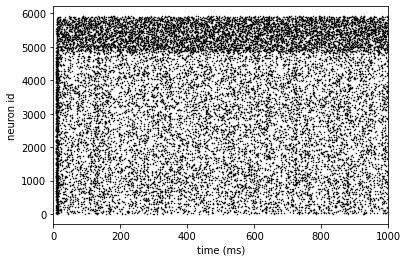

In [16]:
pylab.plot(spike_times, spike_senders, 'k.', markersize=1)
pylab.xlim(0,T)
#pylab.ylim(pop_L5E[0], pop_L5I[-1])
pylab.xlabel('time (ms)')
pylab.ylabel('neuron id')

... and we compute the average firing rate for each population.

**TODO** Determine the average rate per neuron by reading out the number of spikes registered by a spike detector during the simulation time. Pay attention to get the correct time units.

In [18]:
rate_E = float(nest.GetStatus(sd_L5E)[0]['n_events']) / T * 1e3 / N_L5E
print("\nFiring rate E = %.1f spikes/s" % (rate_E))

rate_I = float(nest.GetStatus(sd_L5I)[0]['n_events']) / T * 1e3 / N_L5I
print("\nFiring rate I = %.1f spikes/s" % (rate_I))


Firing rate E = 2.3 spikes/s

Firing rate I = 6.4 spikes/s


Besides, NEST also provides build-in plotting tools for creating raster plots.

**TODO** Just uncomment the following lines.

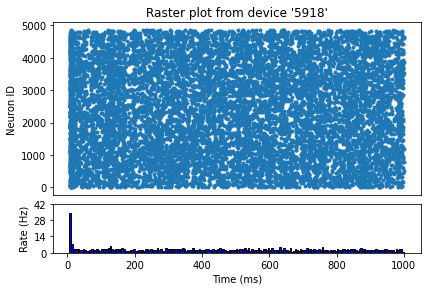

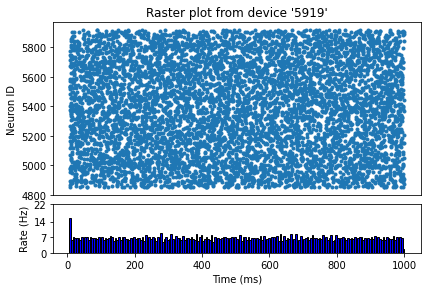

In [19]:
nest.raster_plot.from_device(sd_L5E, hist=True)
nest.raster_plot.from_device(sd_L5I, hist=True)